In [1]:
from qkeras import QConv2D, QDense, QActivation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Flatten, Input, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from qkeras.quantizers import quantized_bits, quantized_relu

model = Sequential()

model.add(
    Input(shape=(28, 28, 1))
)

model.add(
    QConv2D(
        6,
        kernel_size=(5, 5),
        padding='same',
        name='conv1',
        kernel_quantizer=quantized_bits(16, 0, alpha=1),
        bias_quantizer=quantized_bits(16, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001)
    )
)
model.add(QActivation(activation=quantized_relu(16), name='relu1'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(
    QConv2D(
        16,
        kernel_size=(5, 5),
        padding='same',
        name='conv2',
        kernel_quantizer=quantized_bits(16, 0, alpha=1),
        bias_quantizer=quantized_bits(16, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001)
    )
)
model.add(QActivation(activation=quantized_relu(16), name='relu2'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(
    QDense(
        16,
        name='fc1',
        kernel_quantizer=quantized_bits(16, 0, alpha=1),
        bias_quantizer=quantized_bits(16, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001)
    )
)
model.add(QActivation(activation=quantized_relu(16), name='relu3'))

model.add(
    QDense(
        16,
        name='fc2',
        kernel_quantizer=quantized_bits(16, 0, alpha=1),
        bias_quantizer=quantized_bits(16, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001)
    )
)
model.add(QActivation(activation=quantized_relu(16), name='relu4'))

model.add(
    QDense(
        10,
        name='fc3',
        kernel_quantizer=quantized_bits(16, 0, alpha=1),
        bias_quantizer=quantized_bits(16, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001)
    )
)
model.add(QActivation(activation=quantized_relu(16), name='relu5'))

model.add(Activation(activation='softmax', name='softmax'))

model.summary()

2023-06-29 10:25:48.032819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 10:25:49.887347: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (QConv2D)             (None, 28, 28, 6)         156       
                                                                 
 relu1 (QActivation)         (None, 28, 28, 6)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2 (QConv2D)             (None, 14, 14, 16)        2416      
                                                                 
 relu2 (QActivation)         (None, 14, 14, 16)      

In [2]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print('X_train shape', X_train.shape, 'X_test shape', X_test.shape)

X_train shape (60000, 28, 28) X_test shape (10000, 28, 28)


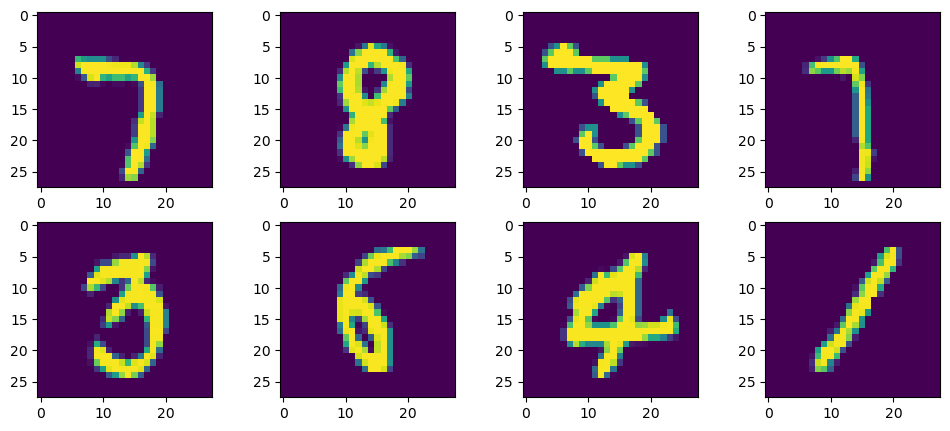

In [3]:
import matplotlib.pyplot as plt 
import random
plt.figure(figsize = (12,5))
for i in range(8):
  ind = random.randint(0, len(X_train))
  plt.subplot(240+1+i)
  plt.imshow(X_train[ind])

In [4]:
from tensorflow.keras.utils import to_categorical

# reshape images to the required size of Keras
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
  
# convert image values from integers to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
  
# normalization
X_train = X_train/255.0
X_test_norm = X_test/255.0
  
# One-hot encoding label 
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [5]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.5, begin_step=2000, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

In [7]:
from tensorflow.keras.optimizers import Adam
adam = Adam()

model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])

model.fit(
    X_train, 
    y_train,
    epochs = 10,
    batch_size = 1024,
    validation_data = (X_test, y_test)
)

model = strip_pruning(model)
model.save('LeNet_Model.h5')


Epoch 1/10
59/59 [==============================] - 11s 128ms/step - loss: 2.1199 - accuracy: 0.4812 - val_loss: 2.1716 - val_accuracy: 0.3149
Epoch 2/10
59/59 [==============================] - 7s 118ms/step - loss: 1.8450 - accuracy: 0.7201 - val_loss: 2.0435 - val_accuracy: 0.4438
Epoch 3/10
59/59 [==============================] - 7s 119ms/step - loss: 1.7117 - accuracy: 0.8400 - val_loss: 1.9637 - val_accuracy: 0.5423
Epoch 4/10
59/59 [==============================] - 7s 119ms/step - loss: 1.6640 - accuracy: 0.8677 - val_loss: 1.9722 - val_accuracy: 0.5023
Epoch 5/10
59/59 [==============================] - 7s 119ms/step - loss: 1.6454 - accuracy: 0.8982 - val_loss: 2.0218 - val_accuracy: 0.4294
Epoch 6/10
59/59 [==============================] - 7s 118ms/step - loss: 1.6345 - accuracy: 0.9223 - val_loss: 1.9934 - val_accuracy: 0.4578
Epoch 7/10
59/59 [==============================] - 7s 118ms/step - loss: 1.6281 - accuracy: 0.9340 - val_loss: 1.9386 - val_accuracy: 0.5336
Epoch

In [8]:
!ls -la

total 156
drwxr-sr-x 3 jovyan users   4096 Jun 29 10:28 .
drwxr-sr-x 7 jovyan users   4096 Jun 29 09:55 ..
drwxr-sr-x 2 jovyan users   4096 Jun 29 09:55 .ipynb_checkpoints
-rw-r--r-- 1 jovyan users  37441 Jun 29 10:28 LeNet_MNIST.ipynb
-rw-r--r-- 1 jovyan users 103344 Jun 29 10:27 LeNet_Model.h5


In [9]:
import os

os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
os.environ['LD_PRELOAD'] = '/lib/x86_64-linux-gnu/libudev.so.1'

In [11]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='name')
config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
for layer in ['fc1', 'fc2', 'fc3', 'softmax']:
    config['LayerName'][layer]['ReuseFactor'] = 64
print("-----------------------------------")
print(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='hls4ml_PYNQ', backend='VivadoAccelerator', board='pynq-z2'
)
hls_model.compile()

Interpreting Sequential
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 1]
Layer name: conv1, layer type: QConv2D, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 6]
Layer name: relu1, layer type: Activation, input shapes: [[None, 28, 28, 6]], output shape: [None, 28, 28, 6]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 28, 28, 6]], output shape: [None, 14, 14, 6]
Layer name: conv2, layer type: QConv2D, input shapes: [[None, 14, 14, 6]], output shape: [None, 14, 14, 16]
Layer name: relu2, layer type: Activation, input shapes: [[None, 14, 14, 16]], output shape: [None, 14, 14, 16]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, input shapes: [[None, 14, 14, 16]], output shape: [None, 7, 7, 16]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 7, 7, 16]], output shape: [None, 784]
Layer name: fc1, layer type: QDense, input shapes: [[None, 784]], output 

In [12]:
hls_model.build(csim=False, export=True, bitfile=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /opt/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/opt/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'jovyan' on host '962d6a010901' (Linux_x86_64 version 4.15.0-212-generic) on Thu Jun 29 10:33:45 UTC 2023
INFO: [HLS 200-10] In directory '/home/jovyan/Internship_Waseda/hls4ml/LeNet/hls4ml_PYNQ'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/home/jovyan/Internship_Waseda/hls4ml/LeNet/hls4ml_PYNQ/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject_axi.cpp' to the project
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to t

ERROR: [BD 5-390] IP definition not found for VLNV: xilinx.com:hls:myproject_axi:1.0 


CSynthesis report not found.
Vivado synthesis report not found.
Cosim report not found.
Timing report not found.


{}